<a href="https://colab.research.google.com/github/neuroidss/EEG-GAN-audio-video/blob/main/EEG_connectivity_Generate_Abstraction%26Anime_Portraits_with_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

In [ ]:
print('Tensorflow version: {}'.format(tf.__version__) )

Tensorflow version: 1.15.2


In [ ]:
#!git clone https://github.com/NVlabs/stylegan2.git
!git clone https://github.com/NVlabs/stylegan2-ada.git

Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.


In [ ]:
%cd /content/stylegan2-ada

/content/stylegan2-ada


In [ ]:
!pip install googledrivedownloader

In [ ]:
#import pretrained_networks
from google_drive_downloader import GoogleDriveDownloader as gdd

#url = 'https://drive.google.com/open?id=1WNQELgHnaqMTq3TlrnDaVkyrAH8Zrjez'
#anime2:
#url = 'https://drive.google.com/open?id=1YckI8gwqPbZBI8X4eaQAJCgWx-CqCTdi'
#anime:
url = 'https://drive.google.com/open?id=1aUrChOhq5jDEddZK1v_Dp1vYNlHSBL9o'
#abstract:
#url = 'https://drive.google.com/open?id=1ie1vWw1JNsfrZWRtMvhteqzVz4mt4KGa'
#'https://drive.google.com/open?id=1BHeqOZ58WZ-vACR2MJkh1ZVbJK2B-Kle'
model_id = url.replace('https://drive.google.com/open?id=', '')

network_pkl = '/content/models/model_%s.pkl' % model_id#(hashlib.md5(model_id.encode()).hexdigest())
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path=network_pkl)
#_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

import pickle

import dnnlib
import dnnlib.tflib as tflib

tflib.init_tf()

with dnnlib.util.open_url(network_pkl) as fp:
        _G, _D, Gs = pickle.load(fp)


In [ ]:
import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

In [ ]:
!pip install tqdm

In [ ]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#!mkdir /content/eeg
#!cp -r -v "/content/gdrive/MyDrive/EEG-GAN-audio-video/eeg/record-[2019.11.13-22.23.59].csv" "/content/eeg/"
#!cp -r -v "/content/gdrive/MyDrive/EEG-GAN-audio-video/eeg/record-[2020.06.28-14.26.09].csv" "/content/eeg/"

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
!mkdir /content/eeg

csv_name = 'record-[2020.06.28-14.26.09].csv'
url = 'https://drive.google.com/open?id=1LtMfr9GduR3semMVgh_6JoUSKbCG8XbH'
#csv_name = 'record-[2019.11.13-22.23.59].csv'
#url = 'https://drive.google.com/open?id=1Nfzi6yT83SBZxtgIYVtYp7C7g_Sq9OdS'
csv_id = url.replace('https://drive.google.com/open?id=', '')
csv_path = '/content/eeg/%s' % csv_name
gdd.download_file_from_google_drive(file_id=csv_id,
                                    dest_path=csv_path)

csv_name = 'record-[2019.11.13-22.23.59].csv'
url = 'https://drive.google.com/open?id=1Nfzi6yT83SBZxtgIYVtYp7C7g_Sq9OdS'
csv_id = url.replace('https://drive.google.com/open?id=', '')
csv_path = '/content/eeg/%s' % csv_name
gdd.download_file_from_google_drive(file_id=csv_id,
                                    dest_path=csv_path)

mkdir: cannot create directory ‘/content/eeg’: File exists


In [ ]:
!pip install mne


In [ ]:
import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, compute_source_psd

from mne.connectivity import spectral_connectivity, seed_target_indices

import pandas as pd
import numpy as np


In [ ]:
    key = 0
    idx = 0

    data_path = '/content/eeg'
    #raw_fname = data_path + '/record-[2019.11.13-22.23.59].gdf'
    #raw = mne.io.read_raw_gdf(raw_fname, preload=True)

    path = data_path

    ch_names = ['FP1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3','Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4','T8','FC6','FC2','F4','F8','AF4','FP2','Fz','Cz']
    data = pd.read_csv(path + '/record-[2019.11.13-22.23.59].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    #ch_names = ['FP1','F3','P3','O1','O2','P4','F4','FP2']
    #data = pd.read_csv(path + '/record-[2020.06.28-14.26.09].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    #data = pd.read_csv(path + '/record-[2020.06.28-00.36.11].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    #data = pd.read_csv(path + '/record-[2020.06.29-19.49.23].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    #print(data)
    data_transpose=np.transpose(data)

    sfreq = 512 
    ch_types=['eeg']*len(ch_names)
    info = mne.create_info(ch_names = ch_names, sfreq = sfreq, ch_types=ch_types)
    #info = mne.create_info(sfreq = sfreq)
    raw = mne.io.RawArray(data_transpose, info)
    #raw.plot()

    # Setup for reading the raw data
    #raw = io.read_raw_fif(raw_fname, verbose=False)
    #events = mne.find_events(raw, stim_channel='STI 014')
    #inverse_operator = read_inverse_operator(fname_inv)
    #raw.info['bads'] = ['MEG 2443', 'EEG 053']

    # picks MEG gradiometers
    #picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)
    picks = ch_names

Creating RawArray with float64 data, n_channels=32, n_times=157376
    Range : 0 ... 157375 =      0.000 ...   307.373 secs
Ready.


In [ ]:
#!pip install imageio==2.9
!pip install imageio==2.4.1
!pip install imageio-ffmpeg==0.4.3 pyspng==0.1.0

In [ ]:
!mkdir '/content/out'

mkdir: cannot create directory ‘/content/out’: File exists


In [ ]:
import imageio
fps=10
out = imageio.get_writer('/content/out/output.mp4', mode='I', fps=fps, codec='libx264', bitrate='16M')
#for img in imgs:
#  out.append_data(np.asarray(img))
#out.close()
            

In [ ]:
#for ch in ch_names:
#  raw.set_channel_types({ch:'eeg'})
#raw.crop(tmax=150)
#raw.crop(tmax=150).resample(100).pick('eeg')



In [ ]:
bands = [[8.,12.]]
#bands = [[4.,7.],[8.,12.],[13.,29.]]
#bands = [[8.,12.],[8.,12.],[8.,12.]]
#bands_name = ['theta','alpha','beta']
datas=[]
for band in range(len(bands)):
 datas.append(raw)
# datas.append(raw.filter(l_freq=bands[band][0], h_freq=bands[band][1],method='iir'))
#theta_data = raw.filter(l_freq=4, h_freq=7,method='iir')
#alpha_data = raw.filter(l_freq=8, h_freq=12,method='iir')
#beta_data = raw.filter(l_freq=13, h_freq=29,method='iir')

In [ ]:
methods = ['coh']
#methods = ['ciplv']
#methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'wpli']
epochs = []
for band in range(len(bands)):
# epochs.append(mne.make_fixed_length_epochs(datas[band], 
#                                            duration=0.1, preload=False))
 epochs.append(mne.make_fixed_length_epochs(datas[band], 
                                            duration=5*1/8, preload=False, overlap=5*1/8-0.1))
# epochs.append(mne.make_fixed_length_epochs(datas[band], duration=1.25, preload=False, overlap=1.15))
#epochs = [mne.make_fixed_length_epochs(theta_data, duration=0.1, preload=False),
#          mne.make_fixed_length_epochs(alpha_data, duration=0.1, preload=False),
#          mne.make_fixed_length_epochs(beta_data, duration=0.1, preload=False)]
#epochs = mne.make_fixed_length_epochs(alpha_data, duration=0.1, preload=False)
#epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=True)
#epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True)
#epochs = mne.make_fixed_length_epochs(raw, duration=1, preload=False)
#event_related_plot = epochs.plot_image(picks=['FP1'])


Not setting metadata
Not setting metadata
3068 matching events found
No baseline correction applied
0 projection items activated


import matplotlib.pyplot as plt

corr_matrix = mne.connectivity.envelope_correlation(alpha_data, combine=None)

first_30 = corr_matrix[0]
last_30 = corr_matrix[-1]
corr_matrices = [first_30, last_30]
color_lims = np.percentile(np.array(corr_matrices), [5, 95])
titles = ['First 30 Seconds', 'Last 30 Seconds']

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Correlation Matrices from First 30 Seconds and Last 30 Seconds')
for ci, corr_matrix in enumerate(corr_matrices):
    ax = axes[ci]
    mpbl = ax.imshow(corr_matrix, clim=color_lims)
    ax.set_xlabel(titles[ci])
fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.2, 0.025, 0.6])
cbar = fig.colorbar(ax.images[0], cax=cax)
cbar.set_label('Correlation Coefficient')

In [ ]:
#fmin=8.
#fmax=13.
fmin=bands[0][0]
fmax=bands[0][1]+1.
          
sfreq = raw.info['sfreq']  # the sampling frequency
#con_methods = ['coh', 'pli', 'ciplv']
con_methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'wpli']
#con_methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli', 'wpli2_debiased']
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
#    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=10)
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs[1][2000:2010], method=con_methods, mode='multitaper', sfreq=sfreq, 
#    faverage=True, mt_adaptive=True, n_jobs=1)
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs[0][2000,2001], method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
#    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    epochs[0][2000:2010], method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.000s..0.623s for estimation (320 points)
    frequencies: 8.0Hz..12.8Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PLV, ciPLV, PPC, PLI, WPLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]


In [ ]:
#freqs1= [[4.,7.],[8.,13.],[14.,30.]]

In [ ]:
#for freq, ii in freqs1:
# sfreq = raw.info['sfreq']  # the sampling frequency
# con_methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'wpli']
# #con_methods = ['coh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli', 'wpli2_debiased']
# con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#    epochs, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=freq[0],
#    fmax=freq[1], faverage=True, mt_adaptive=True, n_jobs=10)


In [ ]:
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c[:, :, 0]

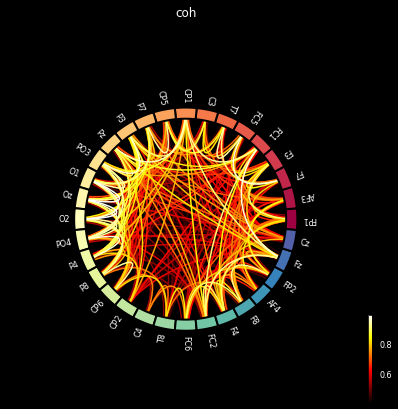

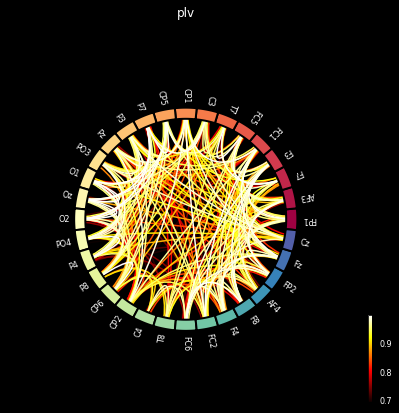

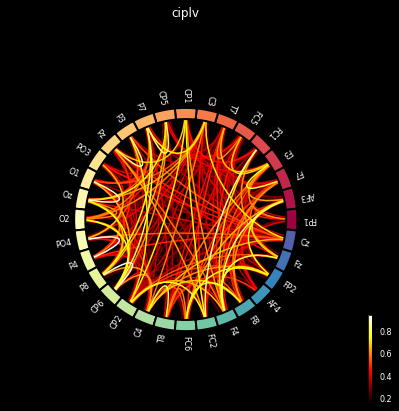

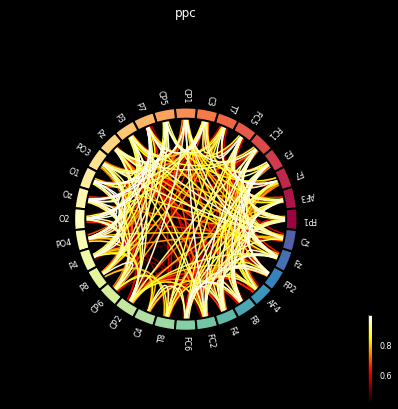

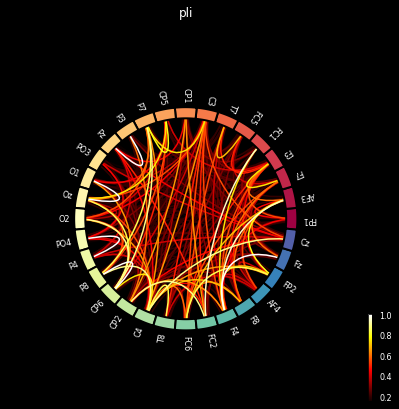

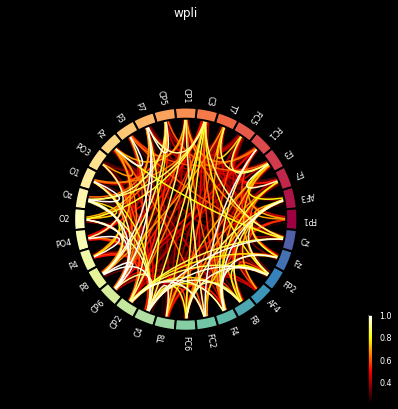

In [ ]:
from mne.viz import circular_layout, plot_connectivity_circle
import matplotlib.pyplot as plt

label_names = ch_names

#plot_connectivity_circle(con_res['pli'], label_names, 
#                                                  title='All-to-All Connectivity (PLI)')
#fig = plt.figure(num=None, figsize=(8, 4), facecolor='black')
no_names = [''] * len(label_names)
for ii, method in enumerate(con_methods):
    plot_connectivity_circle(con_res[method], label_names, n_lines=300,
                             title=method)
    #plot_connectivity_circle(con_res[method], label_names, n_lines=300,
    #                         title=method, padding=0, fontsize_colorbar=6,
    #                         fig=fig, subplot=(1, 8, ii + 1))

    #plot_connectivity_circle(con_res[method], no_names, n_lines=300,
    #                         title=method, padding=0, fontsize_colorbar=6,
    #                         fig=fig, subplot=(1, 6, ii + 1))
plt.show()

In [ ]:
con_res['coh']

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.64715654, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.80520113, 0.60712289, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.71661278, 0.85279984, 0.52570615, ..., 0.        , 0.        ,
        0.        ],
       [0.72335269, 0.77977542, 0.4425438 , ..., 0.77876264, 0.        ,
        0.        ],
       [0.20529402, 0.27715092, 0.24975996, ..., 0.35771778, 0.6327656 ,
        0.        ]])

In [ ]:
#from mne.viz import plot_sensors_connectivity
#plot_sensors_connectivity(epochs.info, con[:, :, 0])

In [ ]:
#from mne.time_frequency import AverageTFR
#tfr = AverageTFR(epochs.info, con, times, freqs, len(epochs))
#tfr.plot_topo(fig_facecolor='w', font_color='k', border='k')

In [ ]:
#import logging
#logging.basicConfig(level='warning')


In [ ]:
# Generate random breaks and display audio

# CHANGE THIS to change number of examples generated
#n_generate = 30
#n_generate = 150
#n_generate = 300
#n_generate = 305
#n_generate = 390

# Sample latent vectors
#seed = 666 # change this seed to generate different set of breaks
#np.random.seed(seed)
#_z = (np.random.rand(n_generate, dim) * 2.) - 1.


hz=44100
#hz=39936
#hz=int(32768*2*(600/240))
#hz=int(32768*2*(480/240))
#hz=int(32768*2*(360/240))
#hz=int(32768*2*(300/240))
#hz=int(32768*2*(265/240))
#hz=int(32768*2*(250/240))
#hz=int(32768*2*(240/240)*1.6666666)
#hz=int(32768*2*(240/240))
#hz=int(32768*2*(120/240))
#fps=hz/(32768*2)
#fps=10
#fps=0.5
#fps=44100/(32768*2)
#fps=1
#fps=1/3
#fps=1.5

#n_generate=int((307-2)*fps)
#n_generate=int((160-2)*fps)
#n_generate=int((1598-2)*fps)
n_generate=int((1648-2)*fps)
#n_generate=int((10-2)*fps)
#n_generate=int((1607-2)*fps)
#n_generate=150
part_len = 10
#part_len = 275
dim = 512


n_parts = n_generate//part_len
if n_generate%part_len>0:
    n_parts=n_parts+1

vol=0.1

psd_array=np.random.rand(part_len, dim) 

#out = imageio.get_writer('./output.mp4', mode='I', fps=fps, codec='libx264', bitrate='16M')

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False

imgs = []
imgs1 = []


#z_avg_samples=n_generate
#for i in range(n_generate): # display separate audio for each break
for j in range(n_parts): # display separate audio for each break
    for i in range(part_len): # display separate audio for each break
        ji = j * part_len + i
        
        if (i==0) and (n_generate-ji<part_len):
            psd_array=np.random.rand((n_generate-ji), dim) 


        eeg_step=ji
        #print (f'EEG step: {(eeg_step/3):.1f} s')
        tmin, tmax = 0+(eeg_step/fps), 2+(eeg_step/fps)  # use the first 120s of data
        #tmin, tmax = 0+(10*eeg_step/512), 2+(10*eeg_step/512)  # use the first 120s of data
        fmin, fmax = 0.5, 256  # look at frequencies between 4 and 100Hz
        #fmin, fmax = 0.5, 50  # look at frequencies between 4 and 100Hz
        #fmin, fmax = 8, 12  # look at frequencies between 4 and 100Hz
        #n_fft = 512  # the FFT size (n_fft). Ideally a power of 2
        n_fft = 1024  # the FFT size (n_fft). Ideally a power of 2
        #n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2
        #label = mne.read_label(fname_label)
        
        print(str(ji) + '/' + str(n_generate))
        #logger = logging.getLogger()
        #logger.disabled = True

        sfreq = raw.info['sfreq']  # the sampling frequency
        
        psds=np.zeros(dim)
        
        for method in range(len(methods)):
         for band in range(len(bands)):
          #fmin=8.
          #fmax=13.
          fmin=bands[band][0]
          fmax=bands[band][1]
          if band == 0:
           con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
            epochs[band][ji:ji+10], method=methods[method], mode='multitaper', sfreq=sfreq, fmin=fmin,
            fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
          #con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
          #  epochs[band][ji,ji+1], method=methods[method], mode='multitaper', sfreq=sfreq, fmin=fmin,
          #  fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
          psds_shift1=int(round(method*len(bands)+band)*(len(ch_names)*(len(ch_names)-1)/2))
          ji1=0
          for j1 in range(0,len(ch_names)): # display separate audio for each break
            for i1 in range(0,j1): # display separate audio for each break
              psds[ji1+psds_shift1]=(con[j1][i1][0]-0.5)*1
              ji1 = ji1+1
        #psds, freqs = mne.time_frequency.psd_welch(raw, picks=picks,
        #                 tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax,
        #                 n_fft=n_fft)
        #logger.disabled = False

        #print(freqs)
        #print(psds)
        
        psd_array[i]=psds
        ##z_samples = psds

        #w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
        #w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
        ##z_avg = np.mean(z_samples, axis=0)      # [1, 1, C]
        #z_avg = np.mean(z_samples, axis=0, keepdims=True)      # [1, 1, C]
        ##psd_array[i]=z_avg
        #psd_array[i]=z_avg
        #print(z_avg)
        #z_std = (np.sum((z_samples - z_avg) ** 2) / z_avg_samples) ** 0.5

        #psd_array[i]=psds
        #psds_transpose=np.transpose(psds)
        #plt.plot(freqs,psds_transpose)
        #plt.xlabel('Frequency (Hz)')
        #plt.ylabel('PSD (dB)')
        #plt.title('Power Spectrum (PSD)')
        #plt.show()
        if (i==part_len-1) or (ji==n_generate-1) :
            
            _z = psd_array * vol
            images = Gs.run(_z, None, **Gs_kwargs) # [minibatch, height, width, channel]
            for image in images:
              #imgs1.append(image)
              out.append_data(np.asarray(PIL.Image.fromarray(image, 'RGB')))

              #imgs.append(PIL.Image.fromarray(image, 'RGB'))
            #out.append(PIL.Image.fromarray(images[0], 'RGB'))
            #_G_z = sess.run(G_z, {z: _z})[:,:,0]
            #if j==0:
            #    _G_z_full=_G_z
            #else:
            #    _G_z_full=np.append(_G_z_full,_G_z)
            if (ji==n_generate-1) :
                break

#print(psd_array)
#print(psd_array.shape)
#print(psd_array.ndim)
#_z = psd_array / 5.
#_z = psd_array / 10.
#_z = (psd_array * 2.) - 1.
#_G_z = sess.run(G_z, {z: _z})[:,:,0]

# display(Audio(_G_z.flatten(), rate=39936)) # display all in one audio

#for i in range(n_generate): # display separate audio for each break
  #print(i)
  #display(Audio(np.tile(_G_z[i][1:_G_z[i].ndim/2], 2), rate=39936)) # change rate for different tempo
  #display(Audio(np.tile(_G_z[i][1:32768], 2), rate=32768)) # change rate for different tempo
  #display(Audio(np.tile(_G_z[i], 1), rate=32768)) # change rate for different tempo
#out.close()


Streaming output truncated to the last 5000 lines.
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
2828/16460
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.000s..0.623s for estimation (320 points)
    frequencies: 8.0Hz..11.2Hz (3 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    assembling connectivity matrix
[Connectivity co

UnboundLocalError: ignored

In [ ]:
#con

In [ ]:
out.close()

In [ ]:
from google.colab import files
files.download('/content/out/output.mp4')

In [ ]:
#stop

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!cp -r -v "/content/out" "/content/gdrive/MyDrive/EEG-GAN-audio-video"

'/content/out/output.mp4' -> '/content/gdrive/MyDrive/EEG-GAN-audio-video/out/output.mp4'


In [ ]:
stop

In [ ]:
min(np.random.randn(10000000))

In [ ]:
max(np.random.randn(10000000))

In [ ]:
imageio.plugins.ffmpeg.download()


In [ ]:
import moviepy.editor
duration_sec=n_generate/fps

def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, n_generate - 1))
    #latents = all_latents[frame_idx]
    return imgs1[frame_idx]

video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif('/content/out/output.gif',fps=fps)



In [ ]:
!cp -r -v "/content/out" "/content/gdrive/MyDrive/EEG-GAN-audio-video"


In [ ]:
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999)#405
filename = 'random_grid_%s.gif' % random_seed
truncation_psi= 0.7

#import moviepy.editor
#video_clip = moviepy.editor.VideoClip(imgs, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

#video_clip.write_gif(filename,fps=15)

In [ ]:
# generate some random seeds
seeds = np.random.randint(10000000, size=9)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, .7)

In [ ]:
imgs[0]

In [ ]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

In [ ]:
createImageGrid(imgs, rows=3)

In [ ]:
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)
createImageGrid(imgs, rows=1)

In [ ]:
import scipy

grid_size = [3, 3]
image_shrink = 1
image_zoom = 1
duration_sec = 5
smoothing_sec = 1.0
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999)#405
filename = 'random_grid_%s.gif' % random_seed
truncation_psi= 0.7

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * len(Gs.input_shape), mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))


def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=truncation_psi,
                          randomize_noise=False, output_transform=fmt, 
                          minibatch_size=16)

    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

# Generate video.
import moviepy.editor
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif(filename,fps=15)

In [ ]:
#video_clip.write_videofile("interpolate.mp4", fps=15, codec='libx264', bitrate='2M')
video_clip.write_gif(filename,fps=15)

In [ ]:
from IPython import display as ipythondisplay
import io
import os
import base64
from IPython.display import HTML

def show_video(vid):
  #mp4list = [video
  #if len(mp4list) > 0:
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  #encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))
  
show_video(filename)